# Generación de datasets y análisis de experimentos
Esta libreta crea los archivos de entrada para el programa C++ y analiza los resultados de las corridas guardadas en `data/results/experiments.csv`.

#### Definición de parámetros

In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

DATA_DIR = Path("../data")
INPUT_DIR = DATA_DIR / "input"
RESULTS_DIR = DATA_DIR / "results"
INPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SIZES = [20000, 40000, 80000, 120000, 140000, 160000, 180000, 200000]
EPSILON = 0.03
MIN_SAMPLES = 10


## Generar archivos `*_data.csv`
Ejecutar esta celda solo si necesitas crear o recrear los datasets (si ya se crearon no es necesario). Cada archivo se guarda con el nombre `{n}_data.csv`.

In [ ]:
def generate_dataset(n_points: int, seed: int = 208450) -> None:
    points, _ = make_blobs(
        n_samples=n_points,
        centers=4,
        cluster_std=0.06,
        random_state=seed,
        center_box=(0, 1.0),
    )
    points = np.round(np.abs(points[:, ::-1]), 3)
    out_path = INPUT_DIR / f"{n_points}_data.csv"
    np.savetxt(out_path, points, delimiter=",")
    print(f"Dataset generado: {out_path}")

#for n in SIZES:
#    generate_dataset(n)


Dataset generado: ../data/input/2000_data.csv
Dataset generado: ../data/input/40000_data.csv
Dataset generado: ../data/input/8000_data.csv
Dataset generado: ../data/input/12000_data.csv
Dataset generado: ../data/input/14000_data.csv
Dataset generado: ../data/input/16000_data.csv
Dataset generado: ../data/input/18000_data.csv
Dataset generado: ../data/input/20000_data.csv


## Analizar resultados experimentales
Se asume que `data/results/experiments.csv` contiene las columnas:

- `points`: número de puntos
- `threads`: hilos usados
- `mode`: `serial`, `parallel_full`, `parallel_divided`
- `time_avg`: tiempo promedio sobre 10 iteraciones
- `time_std`: desviación estándar

,points,threads,mode,time_avg,time_std
0,2000,1,serial,0.019586,0.002282
1,2000,1,parallel_full,0.019134,0.000256
2,2000,4,parallel_full,0.009706,0.000218
3,2000,8,parallel_full,0.008376,0.000722
4,2000,16,parallel_full,0.007423,0.000476


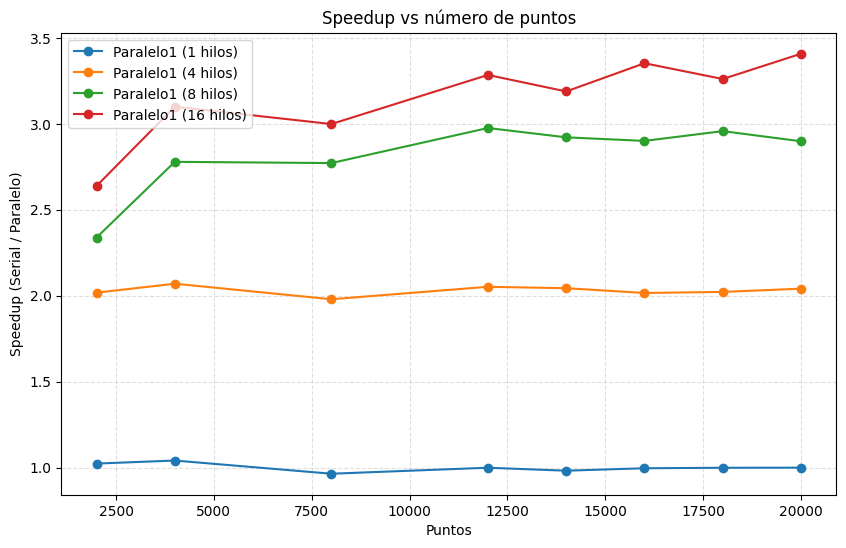

In [11]:
results_path = RESULTS_DIR / "experiments.csv"
if not results_path.exists():
    print(f"No se encontró {results_path}. Ejecuta los experimentos primero.")
else:
    df = pd.read_csv(results_path)
    display(df.head())

    serial_times = (
        df[df["mode"] == "serial"]
        .set_index("points")["time_avg"]
    )

    parallel_full = (
        df[df["mode"] == "parallel_full"]
        .copy()
        .assign(speedup=lambda d: serial_times[d["points"]].to_numpy() / d["time_avg"])
    )

    if "parallel_divided" in df["mode"].values:
        parallel_divided = (
            df[df["mode"] == "parallel_divided"]
            .copy()
            .assign(speedup=lambda d: serial_times[d["points"]].to_numpy() / d["time_avg"])
        )
    else:
        parallel_divided = pd.DataFrame(columns=df.columns)

    plt.figure(figsize=(10, 6))
    for threads, group in parallel_full.groupby("threads"):
        group = group.sort_values("points")
        plt.plot(group["points"], group["speedup"], marker="o",
                 label=f"Paralelo1 ({threads} hilos)")

    if not parallel_divided.empty:
        for threads, group in parallel_divided.groupby("threads"):
            group = group.sort_values("points")
            plt.plot(group["points"], group["speedup"], marker="s", linestyle="--",
                     label=f"Paralelo2 ({threads} hilos)")

    plt.title("Speedup vs número de puntos")
    plt.xlabel("Puntos")
    plt.ylabel("Speedup (Serial / Paralelo)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()
